## Setting up the OpenAI Gym's environment

In [1]:
#!pip install gym
#!pip install pyglet
#!pip install pygame

## [**Cart Pole**](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

![CartPole-v1](https://miro.medium.com/max/1188/1*LVoKXR7aX7Y8npUSsYZdKg.png "CartPole-v1")

| | |
| :-: | :-: |
| Action Space | Discrete(2) |
| Observation Shape | (4,) |
| Observation High | \[4.8 inf 0.42 inf\] |
| Observation Low | \[-4.8 -inf -0.42 -inf\] |
| Import |`gym.make("CartPole-v1")` |

**Description**
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in [“Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”](https://ieeexplore.ieee.org/document/6313077). A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

**Action Space**

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.

| Num | Action |
| :-: | :-: |
| 0 | Push cart to the left |
| 1 | Push cart to the right |
    
**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

**Observations Space**

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation | Min | Max |
| :-: | :-: | :-: | :-: |
| 0 | Cart Position | -4.8 | 4.8 |
| 1 | Cart Velocity | -Inf | Inf |
| 2 | Pole Angle | ~-0.418 rad (-24º) | ~0.418 rad (24º) |
| 3 | Pole Angular Velocity | -Inf | Inf |
    
**Note**: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.

- The pole angle can be observed between `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095`) (or **±12°**)

**Rewards**
    
Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.

**Starting State**
    
All observations are assigned a uniformly random value in `(-0.05, 0.05)`

**Episode End**
    
The episode ends if any one of the following occurs:

1. Termination: Pole Angle is greater than ±12°

2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

3. Truncation: Episode length is greater than 500 (200 for v0)

### Let’s develop a Q-learning and SARSA model to solve this problem

In [2]:
import pygame
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib','inline')

pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Prepare OpenAI Gym Environment

In [3]:
def prepare_env():
    #Environment creation
    env = gym.make("CartPole-v1")#, render_mode='human')

    #Environment values
    #[0] cart position along x-axis
    #[1] cart velocity
    #[2] pole angle (rad) <-------- We will use this
    #[3] pole angular velocity <--- And this
    print('Env. Observation Space: ', env.observation_space)
    print('Env. Observation Space - High:', env.observation_space.high)
    print('Env. Observation Space - Low:', env.observation_space.low)

    # Action Space: [0] push cart to the left / [1] push cart to the right
    print('Env. Action Space: ', env.action_space)
    print('Env. Actions Space: ', env.action_space.n)
    return env



    

In [4]:
prepare_env()

Env. Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Env. Observation Space - High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Env. Observation Space - Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Env. Action Space:  Discrete(2)
Env. Actions Space:  2


<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

### Prepare Reinforcement Learning Model Hyper-parameters

In [5]:
#Hyperparamters
EPISODES =5000
DISCOUNT = 0.95
EPISODE_DISPLAY = 500
LEARNING_RATE = 0.25
EPSILON = 0.2

THETA_STATE_BINS = 50
THETA_DOT_BINS = 50

In [6]:
'''
Let's check our environment and look at the Observation Space!
'''
def check_env(env):
    #Environment values
    #[0] cart position along x-axis
    #[1] cart velocity
    #[2] pole angle (rad) <-------- We will use this
    #[3] pole angular velocity <--- And this
    print('Env. Observation Space: ', env.observation_space)
    print('Env. Observation Space - High:', env.observation_space.high)
    print('Env. Observation Space - Low:', env.observation_space.low)

In [15]:
def discretized_state(state, theta_minmax, theta_dot_minmax):
    #Initialized discrete array
    discrete_state = np.array([0,0])        
    #state[2] -> theta (pole angle in rads)
    theta_window =  ( theta_minmax - (-theta_minmax) ) / THETA_STATE_BINS
    discrete_state[0] = ( state[2] - (-theta_minmax) ) // theta_window
    discrete_state[0] = min(THETA_STATE_BINS-1, max(0,discrete_state[0]))
    #state[3] -> theta_dot (pole angular velocity)
    theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ THETA_DOT_BINS
    discrete_state[1] = ( state[3] - (-theta_dot_minmax) ) // theta_dot_window
    discrete_state[1] = min(THETA_DOT_BINS-1, max(0,discrete_state[1]))
    #return our discrete values as a tuple of ints
    return tuple(discrete_state.astype(np.int32))

### Q-Learning

In [16]:
def train_cart_pole_qlearning():
    #Prepare OpenGym CartPole Environment
    env = gym.make("CartPole-v1")
    check_env(env)
    #Max acceptable values for the features of our Q-Table
    theta_minmax = env.observation_space.high[2]
    theta_dot_minmax = math.radians(50)    
    #Our Q-Table as a shape of (THETA_STATE_BINS * THETA_DOT_BINS * env.action_space.n)
    Q_TABLE = np.random.randn(THETA_STATE_BINS, THETA_DOT_BINS, env.action_space.n)
    #For stats
    ep_rewards = []
    ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}
    #Let's play EPISODES games!
    #This will allow us to optimize/train our Q-Table
    for episode in range(EPISODES):
        #let's see the game every EPISODE_DISPLAY games
        if(episode % EPISODE_DISPLAY == 0):
            render_state = True
            env = gym.make("CartPole-v1")#, render_mode='human')
        else:
            render_state = False
            env = gym.make("CartPole-v1")
        #each game we initialize our reward (and some other vars)
        episode_reward = 0
        done = False
        i = 0
        #... and we get our initial state from the first observation of the environment
        first_obs = env.reset()[0]
        curr_discrete_state = discretized_state(first_obs, theta_minmax, theta_dot_minmax)
        #let's play until we... lose!!
        while(not done):
            #if it is to see the game, let's render it!
            if render_state:
                env.render()
            #EPSILON, i.e., exploration constant (use random actions?) to decide the next action
            if np.random.random() > EPSILON:
                action = np.argmax(Q_TABLE[curr_discrete_state])
            else:
                action = np.random.randint(0, env.action_space.n)
            #Let's execute the action (going left or right)
            #And get the new state of the environment
            new_state, reward, done, _, _ = env.step(action)
            #Let's get the discrete values of the pole's angle and the pole's angular velocity
            new_discrete_state = discretized_state(new_state, theta_minmax, theta_dot_minmax)
            #If we have not yet lost...
            #Let's update our Q-Table using the previous and current state of the environment
            if(not done):
                max_future_q = np.max(Q_TABLE[new_discrete_state])
                current_q = Q_TABLE[curr_discrete_state[0], curr_discrete_state[1], action]
                new_q = current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q - current_q)
                Q_TABLE[curr_discrete_state[0], curr_discrete_state[1], action] = new_q
            i=i+1
            #update the curr_discrete_state and accumulate reward
            curr_discrete_state = new_discrete_state
            episode_reward += reward
        #when finally lost, store the obtained score (i.e., reward)
        ep_rewards.append(episode_reward)
        #each EPISODE_DISPLAY games, show some stats
        if(episode % EPISODE_DISPLAY == 0):
            avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
            ep_rewards_table['ep'].append(episode)
            ep_rewards_table['avg'].append(avg_reward)
            ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
            ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
            print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")
            ep_rewards = []
    #After playing all games, close the environment
    env.close()
    #Plot Model's evolution performance
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
    plt.legend(loc=4) #bottom right
    plt.title('CartPole Q-Learning')
    plt.ylabel('Reward/Episode')
    plt.xlabel('Episodes')
    plt.show()
    #return all stats for future inspection
    
    return ep_rewards_table

### SARSA

In [17]:
def train_cart_pole_sarsa():
    #Prepare OpenGym CartPole Environment
    env = gym.make("CartPole-v1")
    check_env(env)
    #Max acceptable values for the features of our Q-Table
    theta_minmax = env.observation_space.high[2]
    theta_dot_minmax = math.radians(50)    
    #Our Q-Table as a shape of (THETA_STATE_BINS * THETA_DOT_BINS * env.action_space.n)
    Q_TABLE = np.random.randn(THETA_STATE_BINS, THETA_DOT_BINS, env.action_space.n)
    #For stats
    ep_rewards = []
    ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}
    #Let's play EPISODES games!
    #This will allow us to optimize/train our Q-Table
    for episode in range(EPISODES):
        #let's see the game every EPISODE_DISPLAY games
        if(episode % EPISODE_DISPLAY == 0):
            render_state = True
            env = gym.make("CartPole-v1")#, render_mode='human')
        else:
            render_state = False
            env = gym.make("CartPole-v1")
        #each game we initialize our reward (and some other vars)
        episode_reward = 0
        done = False
        i = 0
        #... and we get our initial state from the first observation of the environment
        first_obs = env.reset()[0]
        curr_discrete_state = discretized_state(first_obs, theta_minmax, theta_dot_minmax)
        #EPSILON, i.e., exploration constant (use random actions?) to decide the next action
        if np.random.random() > EPSILON:
            action = np.argmax(Q_TABLE[curr_discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)
        #let's play until we... lose!!
        while(not done):
            #if it is to see the game, let's render it!
            if render_state:
                env.render()
            #Let's execute the action (going left or right)
            #execute our action based on the current state
            new_state, reward, done, _, _ = env.step(action)
            new_discrete_state = discretized_state(new_state, theta_minmax, theta_dot_minmax)
            #see which action we should take next
            if np.random.random() > EPSILON:
                new_action = np.argmax(Q_TABLE[new_discrete_state])
            else:
                new_action = np.random.randint(0, env.action_space.n)             
            #If we have not yet lost...
            #Let's update our Q-Table using the previous and current state of the environment
            if(not done):
                current_q = Q_TABLE[curr_discrete_state+(action,)]			
                max_future_q = Q_TABLE[new_discrete_state+(new_action,)]
                new_q = current_q + LEARNING_RATE*(reward + DISCOUNT*max_future_q - current_q)
                Q_TABLE[curr_discrete_state[0], curr_discrete_state[1], action] = new_q
            i=i+1
            #update the curr_discrete_state and accumulate reward
            curr_discrete_state = new_discrete_state
            action = new_action
            episode_reward += reward
        #when finally lost, store the obtained score (i.e., reward)
        ep_rewards.append(episode_reward)
        #each EPISODE_DISPLAY games, show some stats
        if(episode % EPISODE_DISPLAY == 0):
            avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
            ep_rewards_table['ep'].append(episode)
            ep_rewards_table['avg'].append(avg_reward)
            ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
            ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
            print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")
            ep_rewards = []
    #After playing all games, close the environment
    env.close()
    #Plot Model's evolution performance
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
    plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
    plt.legend(loc=4) #bottom right
    plt.title('CartPole SARSA')
    plt.ylabel('Reward/Episode')
    plt.xlabel('Episodes')
    plt.show()
    #return all stats for future inspection

    
    return ep_rewards_table

### Results: Q-Learning vs SARSA

Env. Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Env. Observation Space - High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Env. Observation Space - Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Episode:0 avg:18.0 min:18.0 max:18.0


/home/lau/anaconda3/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode:500 avg:22.264 min:8.0 max:86.0
Episode:1000 avg:23.988 min:8.0 max:114.0
Episode:1500 avg:37.256 min:8.0 max:226.0
Episode:2000 avg:61.178 min:10.0 max:481.0
Episode:2500 avg:113.336 min:9.0 max:631.0
Episode:3000 avg:180.072 min:9.0 max:939.0
Episode:3500 avg:188.726 min:11.0 max:1172.0
Episode:4000 avg:190.364 min:16.0 max:434.0
Episode:4500 avg:194.878 min:11.0 max:537.0


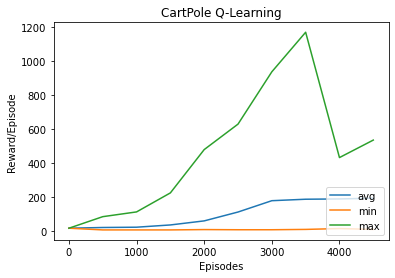

In [18]:
#Q-learning
ep_rewards_table_qlearning = train_cart_pole_qlearning()

Env. Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Env. Observation Space - High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Env. Observation Space - Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Episode:0 avg:38.0 min:38.0 max:38.0
Episode:500 avg:21.904 min:9.0 max:86.0
Episode:1000 avg:22.54 min:8.0 max:86.0
Episode:1500 avg:39.842 min:8.0 max:214.0
Episode:2000 avg:56.754 min:8.0 max:466.0
Episode:2500 avg:65.568 min:8.0 max:746.0
Episode:3000 avg:110.22 min:9.0 max:785.0
Episode:3500 avg:154.906 min:9.0 max:1044.0
Episode:4000 avg:223.886 min:8.0 max:1176.0
Episode:4500 avg:311.822 min:9.0 max:1411.0


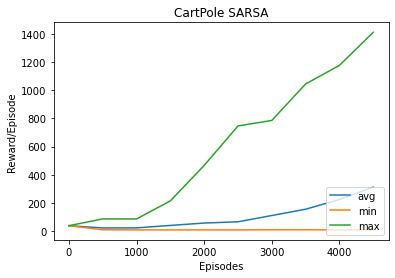

In [19]:
#SARSA
ep_rewards_table_sarsa = train_cart_pole_sarsa()

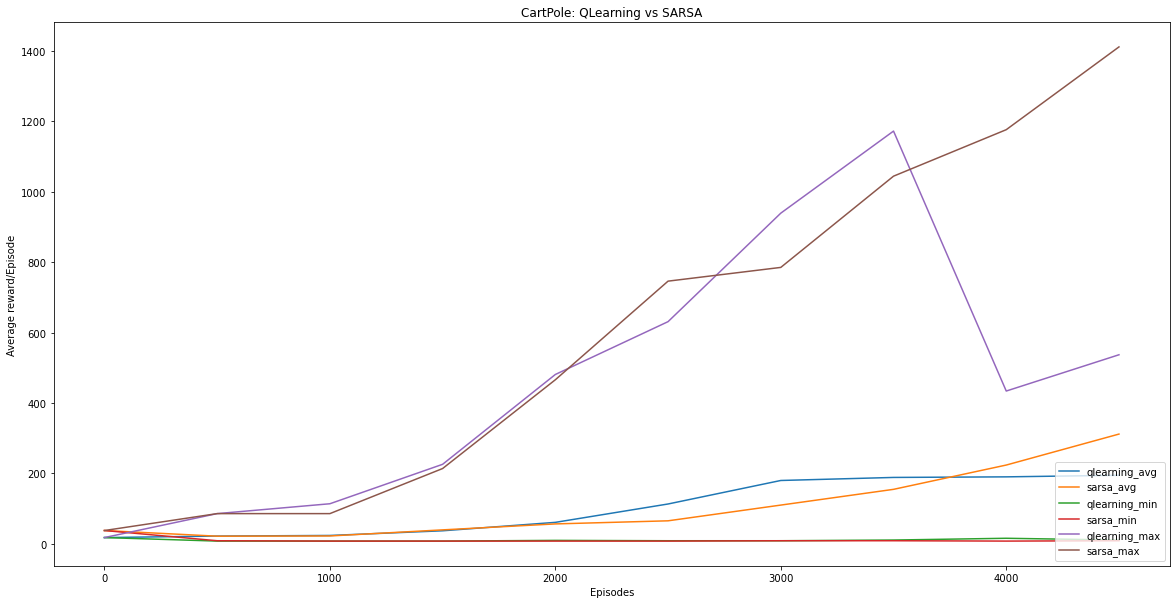

In [21]:
#Comparison
plt.figure(figsize=(20,10)) 
plt.plot(ep_rewards_table_qlearning['ep'], ep_rewards_table_qlearning['avg'], label="qlearning_avg") 

plt.plot(ep_rewards_table_sarsa['ep'], ep_rewards_table_sarsa['avg'], label="sarsa_avg") 
plt.plot(ep_rewards_table_qlearning['ep'], ep_rewards_table_qlearning['min'], label="qlearning_min") 
plt.plot(ep_rewards_table_sarsa['ep'], ep_rewards_table_sarsa['min'], label="sarsa_min") 

plt.plot(ep_rewards_table_qlearning['ep'], ep_rewards_table_qlearning['max'], label="qlearning_max") 
plt.plot(ep_rewards_table_sarsa['ep'], ep_rewards_table_sarsa['max'], label="sarsa_max") 
plt.legend(loc=4) 
#bottom right 
plt.title('CartPole: QLearning vs SARSA') 
plt.ylabel('Average reward/Episode') 
plt.xlabel('Episodes') 
plt.show()
